# Import Libraries

In [24]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

#!pip install albumentations

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [25]:
# Calculate CIFAR10 mean and std
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

'''
# Train Phase transformations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(
        max_holes=1, max_height=16, max_width=16,
        min_holes=1, min_height=16, min_width=16,
        fill_value=CIFAR_MEAN, mask_fill_value=None,
        p=0.5
    ),
    A.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
    ToTensorV2()
])

# Test Phase transformations
test_transforms = A.Compose([
    A.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
    ToTensorV2()
])
'''

# Replace albumentations transforms with torchvision transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [26]:
'''
# Custom dataset wrapper for albumentations
class AlbumentationDataset:
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # Convert to HWC format
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
            
        return image, label
'''

'\n# Custom dataset wrapper for albumentations\nclass AlbumentationDataset:\n    def __init__(self, dataset, transform=None):\n        self.dataset = dataset\n        self.transform = transform\n        \n    def __len__(self):\n        return len(self.dataset)\n    \n    def __getitem__(self, idx):\n        image, label = self.dataset[idx]\n        image = image.numpy().transpose(1, 2, 0)  # Convert to HWC format\n        \n        if self.transform:\n            transformed = self.transform(image=image)\n            image = transformed["image"]\n            \n        return image, label\n'

# Dataset and Creating Train/Test Split

In [27]:
'''
train_data = datasets.CIFAR10('./data', train=True, download=True)
test_data = datasets.CIFAR10('./data', train=False, download=True)

train = AlbumentationDataset(train_data, train_transforms)
test = AlbumentationDataset(test_data, test_transforms)
'''

train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [28]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [29]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
'''
train_data = train.dataset.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.dataset.data.shape)
print(' - Tensor Shape:', train.dataset.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
'''

"\ntrain_data = train.dataset.data\ntrain_data = train.transform(train_data.numpy())\n\nprint('[Train]')\nprint(' - Numpy Shape:', train.dataset.data.shape)\nprint(' - Tensor Shape:', train.dataset.data.size())\nprint(' - min:', torch.min(train_data))\nprint(' - max:', torch.max(train_data))\nprint(' - mean:', torch.mean(train_data))\nprint(' - std:', torch.std(train_data))\nprint(' - var:', torch.var(train_data))\n\ndataiter = iter(train_loader)\nimages, labels = next(dataiter)\n\nprint(images.shape)\nprint(labels.shape)\n\n# Let's visualize some of the images\n%matplotlib inline\nimport matplotlib.pyplot as plt\n\nplt.imshow(images[0].numpy().squeeze(), cmap='gray_r')\n"

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [30]:
"""
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
"""

"\nfigure = plt.figure()\nnum_of_images = 60\nfor index in range(1, num_of_images + 1):\n    plt.subplot(6, 10, index)\n    plt.axis('off')\n    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')\n"

# The model
Let's start with the model we first saw

In [31]:

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, 
                                  stride=stride, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # C1 Block - Reduce initial channels
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 24, 3, padding=1, bias=False),  # RF: 3
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Conv2d(24, 24, 3, padding=1, bias=False),  # RF: 5
            nn.ReLU(),
            nn.BatchNorm2d(24)
        )
        
        # C2 Block with Depthwise Separable Conv
        self.convblock2 = nn.Sequential(
            DepthwiseSeparableConv(24, 36, 3, padding=1),  # RF: 7
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Conv2d(36, 36, 3, stride=2, padding=1, bias=False),  # RF: 11
            nn.ReLU(),
            nn.BatchNorm2d(36)
        )
        
        # C3 Block with Dilated Conv
        self.convblock3 = nn.Sequential(
            nn.Conv2d(36, 48, 3, padding=2, dilation=2, bias=False),  # RF: 19
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Conv2d(48, 48, 3, stride=2, padding=1, bias=False),  # RF: 27
            nn.ReLU(),
            nn.BatchNorm2d(48)
        )
        
        # C4 Block
        self.convblock4 = nn.Sequential(
            nn.Conv2d(48, 64, 3, padding=1, bias=False),  # RF: 35
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1, bias=False),  # RF: 51
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        
        # GAP + FC
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(-1, 64)
        x = self.dropout(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [32]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
       BatchNorm2d-3           [-1, 24, 32, 32]              48
            Conv2d-4           [-1, 24, 32, 32]           5,184
              ReLU-5           [-1, 24, 32, 32]               0
       BatchNorm2d-6           [-1, 24, 32, 32]              48
            Conv2d-7           [-1, 24, 32, 32]             240
            Conv2d-8           [-1, 36, 32, 32]             900
DepthwiseSeparableConv-9           [-1, 36, 32, 32]               0
             ReLU-10           [-1, 36, 32, 32]               0
      BatchNorm2d-11           [-1, 36, 32, 32]              72
           Conv2d-12           [-1, 36, 16, 16]          11,664
             ReLU-13           [-1, 36, 16, 16]               0
      BatchNorm2d-14          

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [33]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Add scheduler step
    scheduler.step()


    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [34]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    epochs=30,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=10
)
EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]

Loss=1.2471481561660767 Batch_id=390 Accuracy=41.68: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]



Test set: Average loss: 1.3778, Accuracy: 4963/10000 (49.63%)

EPOCH: 1


Loss=1.2116022109985352 Batch_id=390 Accuracy=56.44: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]



Test set: Average loss: 1.2090, Accuracy: 5716/10000 (57.16%)

EPOCH: 2


Loss=0.9663490056991577 Batch_id=390 Accuracy=62.53: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s]



Test set: Average loss: 0.9445, Accuracy: 6681/10000 (66.81%)

EPOCH: 3


Loss=0.9710149765014648 Batch_id=390 Accuracy=67.01: 100%|██████████| 391/391 [00:29<00:00, 13.11it/s]



Test set: Average loss: 0.9287, Accuracy: 6787/10000 (67.87%)

EPOCH: 4


Loss=0.8730276226997375 Batch_id=390 Accuracy=69.65: 100%|██████████| 391/391 [00:25<00:00, 15.04it/s]



Test set: Average loss: 0.7935, Accuracy: 7221/10000 (72.21%)

EPOCH: 5


Loss=0.8064290285110474 Batch_id=390 Accuracy=71.71: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s]



Test set: Average loss: 0.9057, Accuracy: 6890/10000 (68.90%)

EPOCH: 6


Loss=0.6490942239761353 Batch_id=390 Accuracy=73.14: 100%|██████████| 391/391 [00:25<00:00, 15.24it/s]



Test set: Average loss: 0.7523, Accuracy: 7426/10000 (74.26%)

EPOCH: 7


Loss=0.6334226131439209 Batch_id=390 Accuracy=73.86: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s]



Test set: Average loss: 0.7272, Accuracy: 7483/10000 (74.83%)

EPOCH: 8


Loss=0.7426416873931885 Batch_id=390 Accuracy=74.88: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s]



Test set: Average loss: 0.6959, Accuracy: 7594/10000 (75.94%)

EPOCH: 9


Loss=0.9474209547042847 Batch_id=390 Accuracy=75.33: 100%|██████████| 391/391 [00:26<00:00, 14.87it/s] 



Test set: Average loss: 0.6800, Accuracy: 7682/10000 (76.82%)

EPOCH: 10


Loss=0.8421986699104309 Batch_id=390 Accuracy=75.95: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s] 



Test set: Average loss: 0.7024, Accuracy: 7591/10000 (75.91%)

EPOCH: 11


Loss=0.7594251036643982 Batch_id=390 Accuracy=76.29: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s] 



Test set: Average loss: 0.6290, Accuracy: 7894/10000 (78.94%)

EPOCH: 12


Loss=0.6533401608467102 Batch_id=390 Accuracy=76.90: 100%|██████████| 391/391 [00:28<00:00, 13.80it/s] 



Test set: Average loss: 0.6798, Accuracy: 7691/10000 (76.91%)

EPOCH: 13


Loss=0.5397074818611145 Batch_id=390 Accuracy=77.07: 100%|██████████| 391/391 [00:27<00:00, 14.16it/s] 



Test set: Average loss: 0.6652, Accuracy: 7745/10000 (77.45%)

EPOCH: 14


Loss=0.7841891050338745 Batch_id=390 Accuracy=77.67: 100%|██████████| 391/391 [00:26<00:00, 14.80it/s] 



Test set: Average loss: 0.6490, Accuracy: 7810/10000 (78.10%)

EPOCH: 15


Loss=0.46818026900291443 Batch_id=390 Accuracy=77.87: 100%|██████████| 391/391 [00:26<00:00, 15.01it/s]



Test set: Average loss: 0.5550, Accuracy: 8085/10000 (80.85%)

EPOCH: 16


Loss=0.7581078410148621 Batch_id=390 Accuracy=78.48: 100%|██████████| 391/391 [00:26<00:00, 14.95it/s] 



Test set: Average loss: 0.6434, Accuracy: 7783/10000 (77.83%)

EPOCH: 17


Loss=0.6685738563537598 Batch_id=390 Accuracy=78.77: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s] 



Test set: Average loss: 0.6466, Accuracy: 7765/10000 (77.65%)

EPOCH: 18


Loss=0.5770926475524902 Batch_id=390 Accuracy=79.16: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s] 



Test set: Average loss: 0.6358, Accuracy: 7833/10000 (78.33%)

EPOCH: 19


Loss=0.6417855024337769 Batch_id=390 Accuracy=79.67: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s] 



Test set: Average loss: 0.5561, Accuracy: 8099/10000 (80.99%)

EPOCH: 20


Loss=0.49802976846694946 Batch_id=390 Accuracy=80.29: 100%|██████████| 391/391 [00:37<00:00, 10.48it/s]



Test set: Average loss: 0.5549, Accuracy: 8121/10000 (81.21%)

EPOCH: 21


Loss=0.40829330682754517 Batch_id=390 Accuracy=80.84: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s]



Test set: Average loss: 0.5373, Accuracy: 8173/10000 (81.73%)

EPOCH: 22


Loss=0.5126785039901733 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s] 



Test set: Average loss: 0.4967, Accuracy: 8324/10000 (83.24%)

EPOCH: 23


Loss=0.8544145822525024 Batch_id=390 Accuracy=82.24: 100%|██████████| 391/391 [00:31<00:00, 12.28it/s] 



Test set: Average loss: 0.4687, Accuracy: 8380/10000 (83.80%)

EPOCH: 24


Loss=0.5082181692123413 Batch_id=390 Accuracy=83.06: 100%|██████████| 391/391 [00:30<00:00, 12.78it/s] 



Test set: Average loss: 0.4677, Accuracy: 8395/10000 (83.95%)

EPOCH: 25


Loss=0.34135952591896057 Batch_id=390 Accuracy=84.22: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]



Test set: Average loss: 0.4269, Accuracy: 8590/10000 (85.90%)

EPOCH: 26


Loss=0.5119417905807495 Batch_id=390 Accuracy=85.11: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s] 



Test set: Average loss: 0.4089, Accuracy: 8592/10000 (85.92%)

EPOCH: 27


Loss=0.36295294761657715 Batch_id=390 Accuracy=85.77: 100%|██████████| 391/391 [00:28<00:00, 13.67it/s]



Test set: Average loss: 0.3931, Accuracy: 8645/10000 (86.45%)

EPOCH: 28


Loss=0.3352167308330536 Batch_id=390 Accuracy=86.55: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s] 



Test set: Average loss: 0.3867, Accuracy: 8661/10000 (86.61%)

EPOCH: 29


Loss=0.3508368134498596 Batch_id=390 Accuracy=86.56: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s] 



Test set: Average loss: 0.3857, Accuracy: 8666/10000 (86.66%)



Text(0.5, 1.0, 'Test Accuracy')

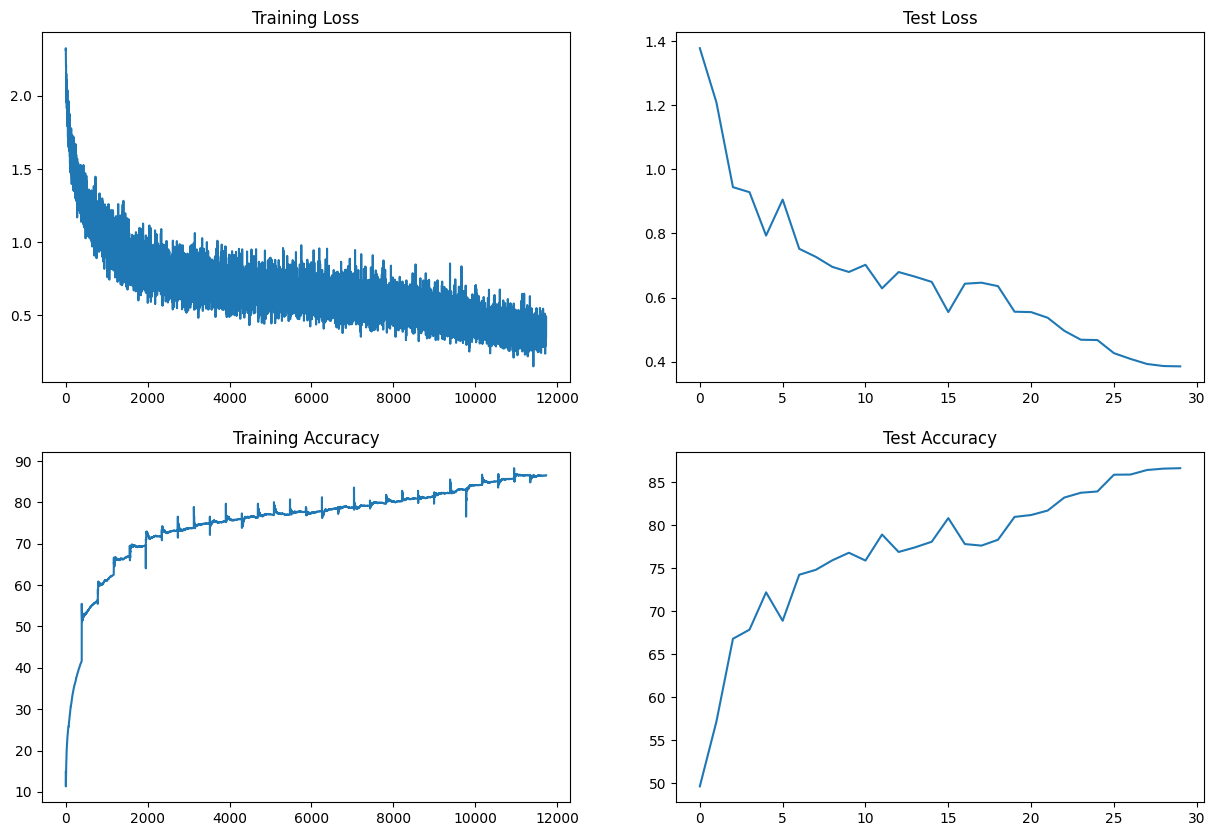

In [35]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")